In [1]:
%matplotlib inline

## Import Libraries

MNE, numpy, matplotlib, Keras

======================================================================

In [2]:
import numpy as np
from numpy.lib import scimath

from matplotlib import pyplot as plt

from mne import create_info, EpochsArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_array_stockwell, tfr_array_morlet, tfr_stockwell, tfr_morlet)

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras
print(__doc__)

Using TensorFlow backend.


Automatically created module for IPython interactive environment


## Data Generation (Synthetic Electromagnetic Time Series)
-------------

Data with a known spectro-temporal structure and randoom noise.

======================================================================

In [ ]:
# constants & parameters
sfreq = 1024                       # sampling frequency in Hz (<--  this can be changed)
n_times =  1024                    # no. of samples  
time_length = n_times / sfreq      # time recording in s (<--  this can be changed)
t = np.arange(n_times, dtype=np.float) / sfreq 
angle = 45    # in degrees from the N to the E (<--  this can be changed)
B_mag = 10    # in nT (<--  this can be changed)
phase_B = 0   # in rad (if any phase is included) (<--  this can be changed)
Freq = 120   # frequency of the signal in Hz (<--  this can be changed)
arg = 2*np.pi*Freq*t
df = 1/time_length   # discretization at frequency domain
fr_N = sfreq/2   # Nyquist frequency
rho = 100   # resistivity of a homogenenous half space in ohm m (<--  this can be changed)

# Bx (NS) and By (EW)
B = B_mag*np.exp(1j*(arg+phase_B))     # complex B(t) along the polarization direction 
Bx = B*np.cos(angle*np.pi/180)         # complex Bx(t) component
By = B*np.sin(angle*np.pi/180)         # complex By(t) component
Bx_f = np.fft.fft(Bx)
By_f = np.fft.fft(By)

# complex impedance matrix (Z)
f = np.linspace(df*(n_times/2-n_times), df*(n_times/2), n_times)
Z = scimath.sqrt(5*f*rho)*np.exp(+1j*np.pi/4)  # complex impedance (units mV/km & nT)
Z_s = np.fft.ifftshift(Z) # computation of inmpedances (frequency domain) homogeneous half space case!
Zxx = 0*Z_s 
Zxy = Z_s 
Zyx = -Z_s 
Zyy = Zxx 

# computation of the Ex and Ey components (frequency domain: E=ZB)
Ex_f = Zxx*Bx_f+Zxy*By_f   # computation of Ex & Ey in frequency domain
Ey_f = Zyx*Bx_f+Zyy*By_f 
Ex = np.fft.ifft(Ex_f)      # computation of the time series for Ex & Ey (in mV/km)
Ey = np.fft.ifft(Ey_f)

Simulate Noise and add to signal
-------------

We'll simulate data with a known spectro-temporal structure.



In [4]:
noise_mag = 3 # Order of magnitude of the noise reative to the channels

# Gaussian Noise scalated with known initial randoom states for reproducibility
noise_Bx =  np.random.RandomState(10).randn(1, 1, n_times) * noise_mag * np.max(Bx)
noise_By =  np.random.RandomState(20).randn(1, 1, n_times) * noise_mag * np.max(By)
noise_Ex =  np.random.RandomState(30).randn(1, 1, n_times) * noise_mag * np.max(Ex)
noise_Ey =  np.random.RandomState(40).randn(1, 1, n_times) * noise_mag * np.max(Ey) 

# Final noisy data = signal + noise
data_Bx = Bx + noise_Bx
data_By = By + noise_By
data_Ex = Ex + noise_Ex
data_Ey = Ey + noise_Ey

## Plot Electromagnetic Time Series Componets

======================================================================

Text(0.5,1,'Ey')

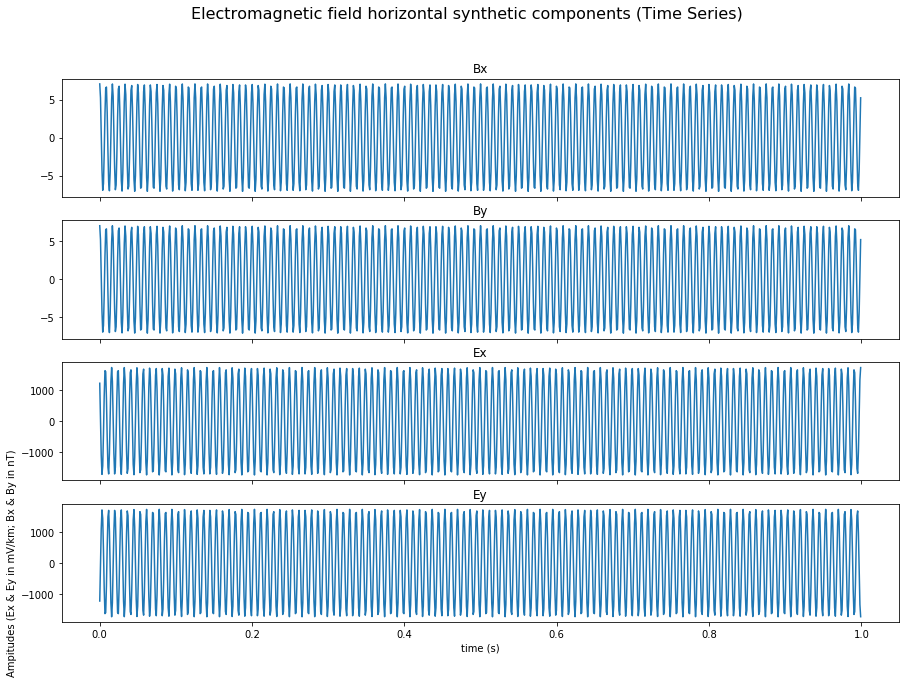

In [5]:
f, axarr = plt.subplots(4, sharex=True)
f.set_size_inches(15,10)
plt.xlabel('time (s)')
plt.ylabel('Ampitudes (Ex & Ey in mV/km; Bx & By in nT)')
plt.suptitle('Electromagnetic field horizontal synthetic components (Time Series)', fontsize=16)

axarr[0].plot(t, Bx.real)
axarr[0].set_title("Bx")
axarr[1].plot(t, By.real)
axarr[1].set_title("By")
axarr[2].plot(t, Ex.real)
axarr[2].set_title("Ex")
axarr[3].plot(t, Ey.real)
axarr[3].set_title("Ey")

## Plot Electromagnetic Noisy Time Series Componets

======================================================================

Text(0.5,1,'Ey')

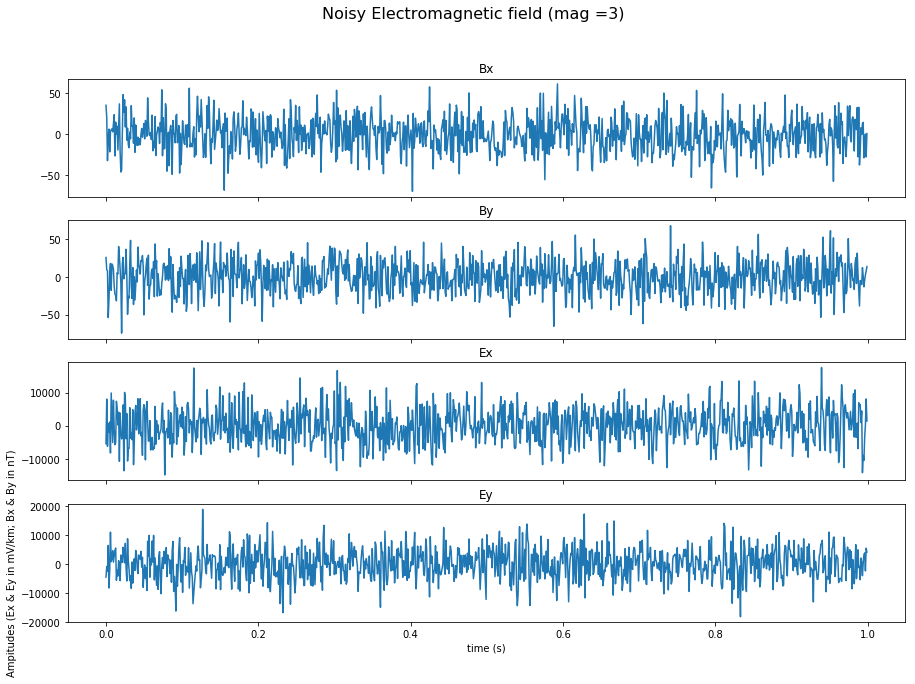

In [6]:
f, axarr = plt.subplots(4, sharex=True)
f.set_size_inches(15,10)
plt.xlabel('time (s)')
plt.ylabel('Ampitudes (Ex & Ey in mV/km; Bx & By in nT)')
plt.suptitle('Noisy Electromagnetic field (mag ='+str(noise_mag)+')', fontsize=16)

axarr[0].plot(t,data_Bx[0,0,:].real)
axarr[0].set_title("Bx")
axarr[1].plot(t,data_By[0,0,:].real)
axarr[1].set_title("By")
axarr[2].plot(t,data_Ex[0,0,:].real)
axarr[2].set_title("Ex")
axarr[3].plot(t,data_Ey[0,0,:].real)
axarr[3].set_title("Ey")

Stockwell (S) transform
=======================

Stockwell uses a Gaussian window to balance temporal and spectral resolution.
Importantly, frequency bands are phase-normalized, hence strictly comparable
with regard to timing, and, the input signal can be recoverd from the
transform in a lossless way if we disregard numerical errors. In this case,
we control the spectral / temporal resolution by specifying different widths
of the gaussian window using the ``width`` parameter.

TFR function in MNE:
* :func:`mne.time_frequency.tfr_array_stockwell`



In [7]:
sfreq = sfreq #The sampling frequency.
fmin = None # float | The minimum frequency to include. If None defaults to the minimum fft frequency greater than zero.
fmax = None # float | The maximum frequency to include. If None defaults to the maximum fft.
n_fft =  None # int | The length of the windows used for FFT. If None, it defaults to the next 
## power of 2 larger than the signal length.
width = 1 # float | The width of the Gaussian window. If < 1, increased temporal resolution,
# if > 1, increased frequency resolution. Defaults to 1. (classical S-Transform).
decim = 1 # The decimation factor on the time axis. To reduce memory usage.
return_itc = False #  bool | Return intertrial coherence (ITC) as well as averaged power.
n_jobs = 1 # int | Number of parallel jobs to use.

### Calculate the Strasform MNE array function
[st_power_Bx, st_itc_Bx, st_freqs_Bx] = tfr_array_stockwell(data_Bx, sfreq, fmin, fmax, n_fft, width, decim, return_itc, n_jobs)
[st_power_By, st_itc_By, st_freqs_By] = tfr_array_stockwell(data_By, sfreq, fmin, fmax, n_fft, width, decim, return_itc, n_jobs)
[st_power_Ex, st_itc_Ex, st_freqs_Ex] = tfr_array_stockwell(data_Ex, sfreq, fmin, fmax, n_fft, width, decim, return_itc, n_jobs)
[st_power_Ey, st_itc_Ey, st_freqs_Ey] = tfr_array_stockwell(data_Ey, sfreq, fmin, fmax, n_fft, width, decim, return_itc, n_jobs)

### Normalized Strasform
N_st_power_Bx = st_power_Bx[0]/np.amax(st_power_Bx[0])
N_st_power_By = st_power_By[0]/np.amax(st_power_By[0])
N_st_power_Ex = st_power_Ex[0]/np.amax(st_power_Ex[0])
N_st_power_Ey = st_power_Ey[0]/np.amax(st_power_Ey[0])


## Plot Stranform of the Time Series Componets

======================================================================

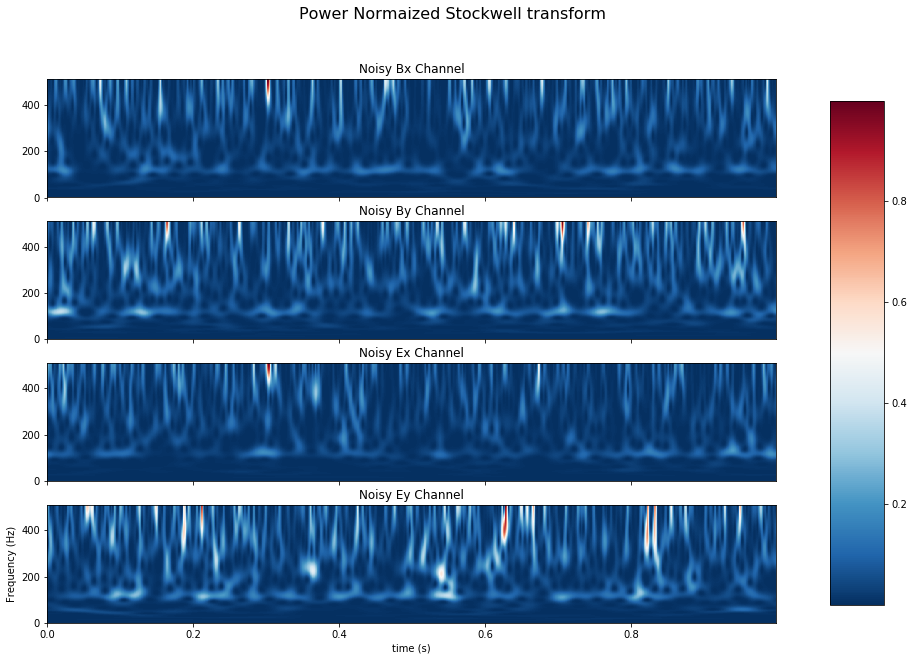

In [8]:
f, axarr = plt.subplots(4, sharex=True)
f.set_size_inches(15,10)

plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.suptitle('Power Normaized Stockwell transform', fontsize=16)

im = axarr[0].pcolormesh(t, st_freqs_Bx, N_st_power_Bx, cmap='RdBu_r')
axarr[0].set_title("Noisy Bx Channel")
axarr[1].pcolormesh(t, st_freqs_By, N_st_power_By, cmap='RdBu_r')
axarr[1].set_title("Noisy By Channel")
axarr[2].pcolormesh(t, st_freqs_Ex, N_st_power_Ex, cmap='RdBu_r')
axarr[2].set_title("Noisy Ex Channel")
axarr[3].pcolormesh(t, st_freqs_Ey, N_st_power_Ey, cmap='RdBu_r')
axarr[3].set_title("Noisy Ey Channel")

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax = cbar_ax)

# Keras LSTM Regression

## Define your training data: input tensors and target tensors.
===================================================================================


In [9]:
# Generate dummy data
x_train = N_st_power_Bx.T
y_train = N_st_power_Ey.T # Ey_f = Zyx * Bx_f + Zyy * By_f 
x_val = N_st_power_By.T
y_val = N_st_power_Ex.T # Ex_f = Zxx * Bx_f + Zxy * By_f

# reshape input to be [samples, timesteps, features] expected input data shape: (batch_size, timesteps, data_dim)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
in_out_neurons = x_train.shape

## Define a network of layers (or model) that maps your inputs to your targets. 


In [10]:
layers = [LSTM(in_out_neurons[2], return_sequences=True, stateful=True, batch_input_shape=(32,1,in_out_neurons[2])),
          LSTM(in_out_neurons[2], return_sequences=True, stateful=True),
          LSTM(in_out_neurons[2]),
          Dense(in_out_neurons[2], activation='linear', use_bias=True)]

model = Sequential(layers)

## Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor (compiling).


In [11]:
RMSprop(lr=100, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Iterate on your training data by calling the fit() method of your model.

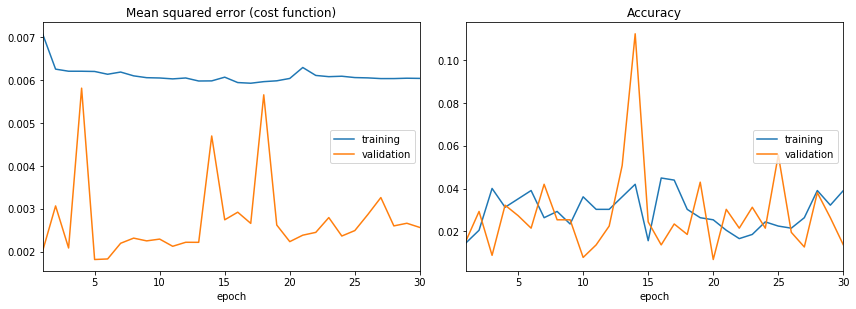

In [12]:
history = model.fit(x_train, y_train,
                    epochs=30,
                    validation_data=(x_val, y_val),
                    callbacks=[PlotLossesKeras()],
                    verbose=0)

## Plot The learned weights 

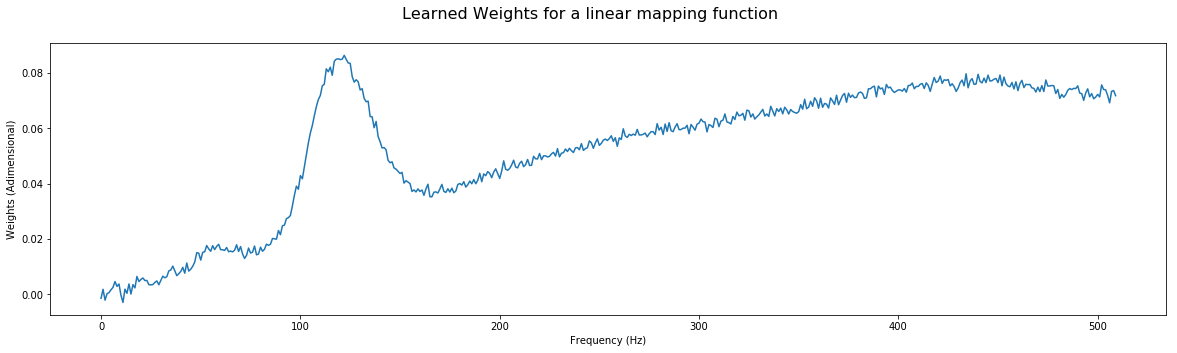

In [13]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    
plt.figure(figsize=(20, 5))    
plt.xlabel('Frequency (Hz)')
plt.ylabel('Weights (Adimensional)')
plt.suptitle('Learned Weights for a linear mapping function', fontsize=16)

plt.plot(weights[-1])

## Predict Denoised Eectromagnetic Components

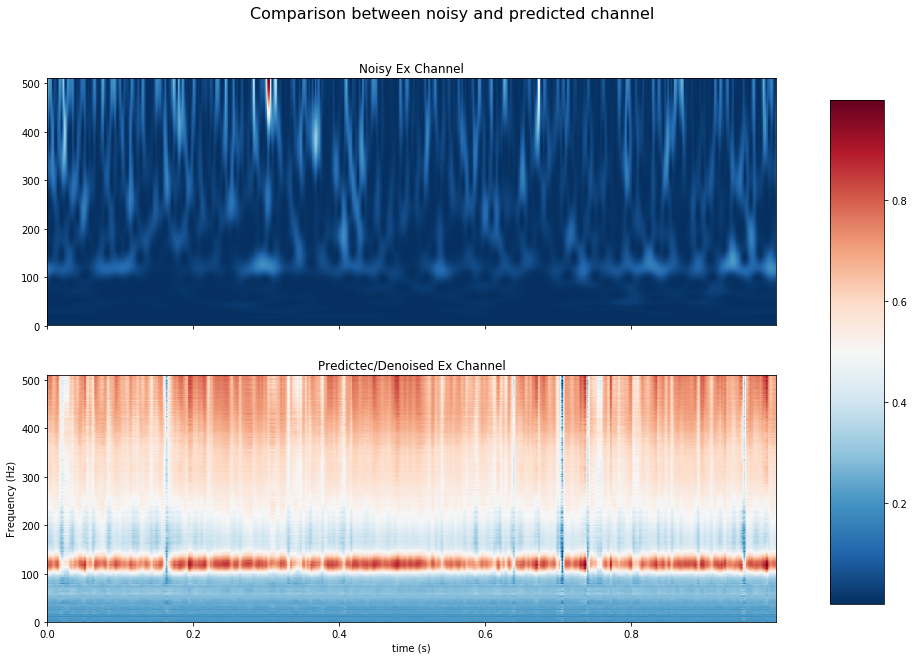

In [14]:
prediction_Ex = model.predict(x_val)

f, axarr = plt.subplots(2, sharex=True)
f.set_size_inches(15,10)

plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.suptitle('Comparison between noisy and predicted channel', fontsize=16)

axarr[0].pcolormesh(t, st_freqs_Ex, N_st_power_Ex, cmap='RdBu_r')
axarr[0].set_title("Noisy Ex Channel")
axarr[1].pcolormesh(t, st_freqs_Ex, prediction_Ex.T, cmap='RdBu_r')
axarr[1].set_title("Predictec/Denoised Ex Channel")

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax = cbar_ax)